In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split


from keras.datasets import mnist
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
# from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
print('Shape of training features: ', X_train.shape)
print('Shape of training labels: ', y_train.shape)
print('Shape of test features: ', X_test.shape)
print('Shape of test labels: ', y_test.shape)

Shape of training features:  (60000, 28, 28)
Shape of training labels:  (60000,)
Shape of test features:  (10000, 28, 28)
Shape of test labels:  (10000,)


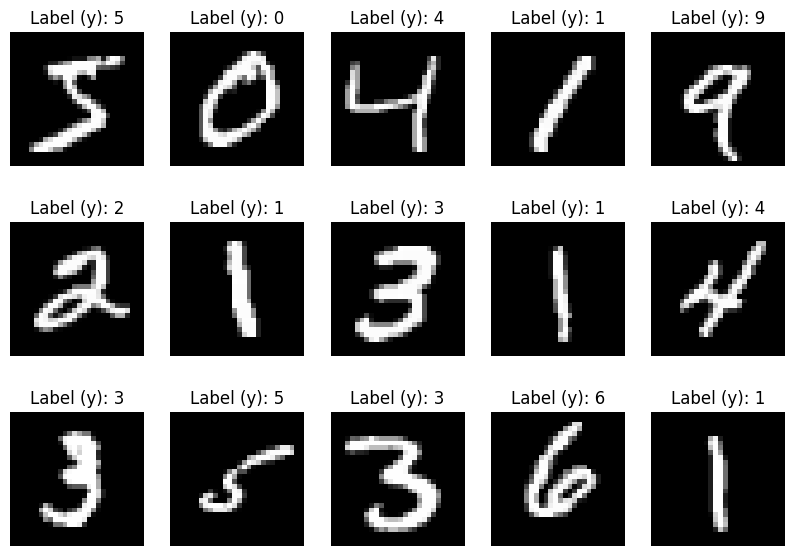

In [4]:
fig = plt.figure(figsize=(10,7))
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)
    ax.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    ax.set_title('Label (y): {y}'.format(y=y_train[i]))
    plt.axis('off')

In [5]:
# flatten each input image into a vector of length 784
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

#Normalising
X_train = X_train/255
X_test = X_test/255

Let's consider the forst 10,000 images in the training dataset and first 2000 images in the testing dataset

In [6]:
X_train = X_train[0:10000, :]
y_train = y_train[0:10000]

X_test = X_test[0:2000, :]
y_test = y_test[0:2000]

Linear SVM

In [7]:
pipe_1 = Pipeline([('scaler', MinMaxScaler()),
                    ('classifier', SVC(kernel='linear', C=1))])

pipe_1.fit(X_train, y_train)

acc = cross_val_score(pipe_1, X_train, y_train, cv=2)
print('Training accuracy: {:.2f} %'.format(acc.mean()*100))

Training accuracy: 91.07 %


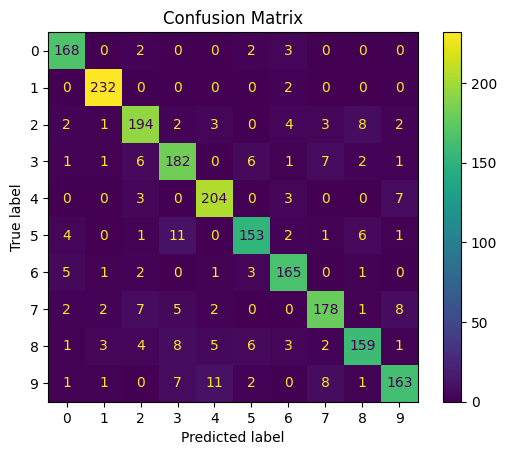

In [8]:
y_pred = pipe_1.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       175
           1       0.96      0.99      0.98       234
           2       0.89      0.89      0.89       219
           3       0.85      0.88      0.86       207
           4       0.90      0.94      0.92       217
           5       0.89      0.85      0.87       179
           6       0.90      0.93      0.91       178
           7       0.89      0.87      0.88       205
           8       0.89      0.83      0.86       192
           9       0.89      0.84      0.86       194

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



Nonlinear SVM for MNIST multiclass classification

In [10]:
pipe_2 = Pipeline([('scaler', MinMaxScaler()),
                    ('classifier', SVC(kernel='rbf', gamma =0.1, C=1))])

pipe_2.fit(X_train, y_train)

acc = cross_val_score(pipe_2, X_train, y_train, cv=2)
print('Training accuracy: {:.2f} %'.format(acc.mean()*100))

Training accuracy: 82.87 %


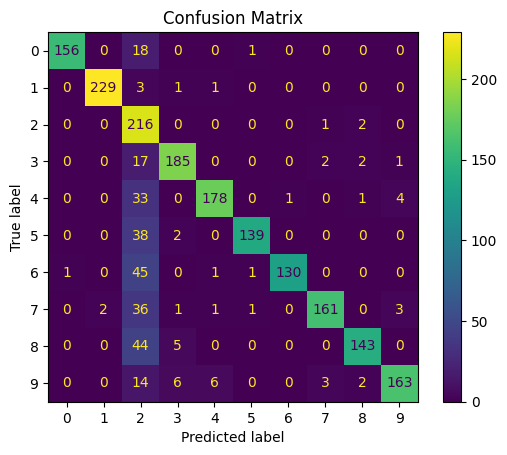

In [11]:
y_pred = pipe_2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

poor performance

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       175
           1       0.99      0.98      0.98       234
           2       0.47      0.99      0.63       219
           3       0.93      0.89      0.91       207
           4       0.95      0.82      0.88       217
           5       0.98      0.78      0.87       179
           6       0.99      0.73      0.84       178
           7       0.96      0.79      0.87       205
           8       0.95      0.74      0.84       192
           9       0.95      0.84      0.89       194

    accuracy                           0.85      2000
   macro avg       0.92      0.84      0.86      2000
weighted avg       0.91      0.85      0.86      2000



2 has a very poor performance. this performance can be optimized by using hyperparameter tuning. here we will adjust C (which controls the margin hardness) and gamma (which controls the size of the radial basis function kernel), and determine the best model

Using GridSearchCV for HPT


this will take a lot of time :)

In [13]:
scaler = StandardScaler()

X_train =  scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma = gamma_range, C = C_range)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(kernel = 'rbf'), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f" %(grid.best_params_, grid.best_score_))

The best parameters are {'C': 10.0, 'gamma': 0.001} with a score of 0.95


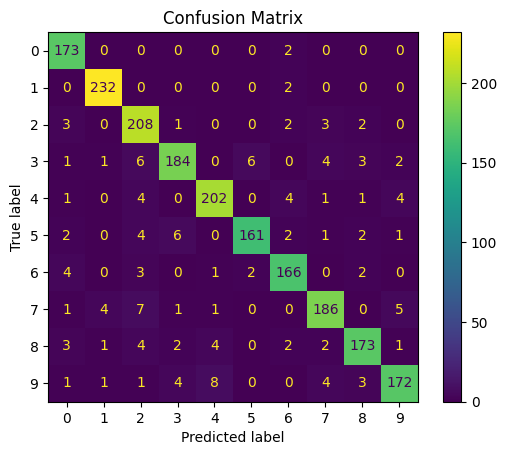

In [14]:
y_pred = grid.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       175
           1       0.97      0.99      0.98       234
           2       0.88      0.95      0.91       219
           3       0.93      0.89      0.91       207
           4       0.94      0.93      0.93       217
           5       0.95      0.90      0.93       179
           6       0.92      0.93      0.93       178
           7       0.93      0.91      0.92       205
           8       0.93      0.90      0.92       192
           9       0.93      0.89      0.91       194

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

